# **TASK 3 : Customer Segmentation / Clustering**
## 1. Load Required Libraries and Data
### Import required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load the datasets

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

### Inspect the data

In [3]:
print(customers.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15


In [4]:
print(transactions.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


## 2. Prepare the Data for Clustering

### 1. Aggregate Transaction Data: Compute total spending and transaction count for each customer.

In [5]:
transaction_agg = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TotalValue': 'TotalSpending', 'TransactionID': 'TransactionCount'})

# Merge with customer profile data
customer_data = customers.merge(transaction_agg, on='CustomerID', how='inner')
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  TotalSpending  \
0      C0001    Lawrence Carroll  South America  2022-07-10        3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13        1862.74   
2      C0003      Michael Rivera  South America  2024-03-07        2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09        5354.88   
4      C0005         Laura Weber           Asia  2022-08-15        2034.24   

   TransactionCount  
0                 5  
1                 4  
2                 4  
3                 8  
4                 3  


### 2. Select Features for Clustering: Use relevant numerical features (e.g., TotalSpending, TransactionCount, Region as encoded values).

In [6]:
customer_data['Region'] = customer_data['Region'].astype('category').cat.codes

features = customer_data[['Region', 'TotalSpending', 'TransactionCount']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## 3. Apply Clustering Algorithm

### Choose K (Number of Clusters): Use the Elbow Method to identify an optimal number of clusters:

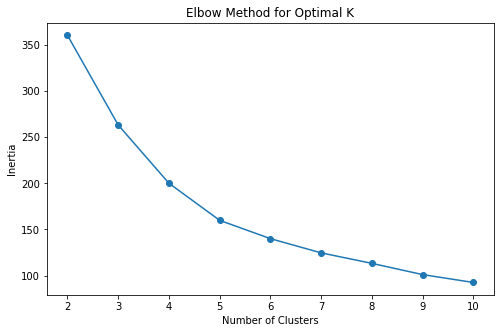

In [7]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


### 3. Run KMeans Clustering: Select the optimal number of clusters (e.g., 4) based on the Elbow Curve.

In [8]:
optimal_k = 4  # Adjust based on Elbow Curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

## 4. Evaluate Clustering

### 1. Calculate Metrics: Compute Davies-Bouldin Index and Silhouette Score:

In [9]:
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.0263175177945745
Silhouette Score: 0.3477316347835255


## 2. Analyze Clusters: Summarize key characteristics of each cluster:

In [10]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'Region': 'mean'
})
print(cluster_summary)

        TotalSpending          TransactionCount           Region
                 mean   median             mean median      mean
Cluster                                                         
0         2405.910667  2592.97         3.783333    4.0  2.516667
1         5051.362667  5053.83         7.133333    7.0  2.622222
2         2099.766364  2138.26         3.400000    3.0  0.527273
3         5201.088462  4982.88         6.794872    7.0  0.538462


## 5. Visualize Clusters

### 1. Scatter Plot of Clusters: Visualize clusters using key features:

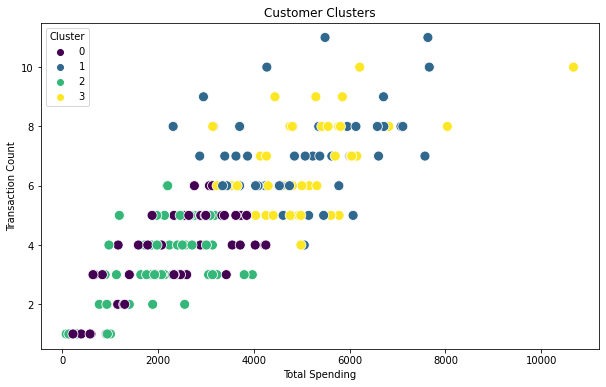

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data['TotalSpending'],
    y=customer_data['TransactionCount'],
    hue=customer_data['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Clusters')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()


### 2. Cluster Centers: Show cluster centroids for interpretability:

In [12]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"Cluster Centers (Unscaled): {centers}")

Cluster Centers (Unscaled): [[2.51666667e+00 2.40591067e+03 3.78333333e+00]
 [2.62222222e+00 5.05136267e+03 7.13333333e+00]
 [5.27272727e-01 2.09976636e+03 3.40000000e+00]
 [5.38461538e-01 5.20108846e+03 6.79487179e+00]]
